<a href="https://colab.research.google.com/github/Dayo-Olalere/2020_FORCE_Lithology_Prediction/blob/main/1Dayo_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Implementation

## About the data
Census Income Dataset contains weighted census data extracted from the 1994 and 1995 Current Population Surveys conducted by the U.S. Census Bureau. It is also known as "Adult" dataset.

**OBJECTIVE:**  Predict whether income exceeds $50K/yr based on census data.

*   If labels=0: The person's income doesn't exceed $50K/yr.

*   If labels=1: The person's income exceeds $50K/yr.




## Steps
1. Understanding the problem and importing necessary packages.
2. Loading the data and viewing its contents.
3. Performing basic Feature Engineering.
4. Splitting our data into train and test sets. (We also kept the non processed data aside so as to directly use it for interpretation).
5. Building and training extreme gradient boosting machine learning model(XGBClassifier)
6. Making predictions on the test data
7. Model Performance Evaluation
8. Explaining the model with SHAP
  - Predicting when a person’s income <= $50K

  - Predicting when a person’s income > $50K

  - Visualizing and explaining multiple predictions

  - Feature Importances with SHAP

  - SHAP Summary Plot

  - SHAP Dependence Plots

## Import Packages

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 4.3MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463907 sha256=ff2d8b051452078e26cbd731a82452eddb713d54f7ff65313d44f6c364acdd36
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

import shap

# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

## Load and View the Census Income Dataset
You can actually get the census income dataset (popularly known as the adult dataset) from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/adult). Fortunately shap provides us an already cleaned up version of this dataset which we will be using here.

In [29]:
#getting the data and labels from the dataset
data, labels = shap.datasets.adult(display=True)

#storing the labels as an numpy array
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


Age          Workclass  ...  Hours per week         Country
0  39.0          State-gov  ...            40.0   United-States
1  50.0   Self-emp-not-inc  ...            13.0   United-States
2  38.0            Private  ...            40.0   United-States
3  53.0            Private  ...            40.0   United-States
4  28.0            Private  ...            40.0            Cuba

[5 rows x 12 columns]

## Viewing the Class Labels Distribution
Let’s view the distribution of people with `<= $50K (labels=0)` and `> $50K (labels=1)` income which are our class labels that we want to predict.

In [30]:
#seeing the distribution of class labels
pd.Series(labels).value_counts()

0    24720
1     7841
dtype: int64

There exists some class imbalance which is expected given that we should have less people having a higher income.

## Basic Feature Engineering
Here we convert the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don’t one-hot encode the features here.




In [31]:
cat_cols = data.select_dtypes(['category']).columns # Storing names of all categorical columns in cat_cols
cat_cols

Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [32]:
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes) # Converting the categorical columns into numerical columns
data.head()

Age  Workclass  Education-Num  ...  Capital Loss  Hours per week  Country
0  39.0          7           13.0  ...           0.0            40.0       39
1  50.0          6           13.0  ...           0.0            13.0       39
2  38.0          4            9.0  ...           0.0            40.0       39
3  53.0          4            7.0  ...           0.0            40.0       39
4  28.0          4           13.0  ...           0.0            40.0        5

[5 rows x 12 columns]

Time to build our train and test datasets before we build our classification model.

## Building Train and Test Datasets
For any machine learning model, we always need train and test datasets. We will be building the model on the train dataset and test the performance on the test dataset. 

We will maintain two datasets:
* One with the encoded categorical values will be used for training our model. (X_train, X_test, y_train, y_test)
* One with the original values will be used for model interpretation since we'll be able to see actual values and not encoded values on the graphs. (X_train_disp, X_test_disp, y_train_disp, y_test_disp)

### Processed Dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head()

(22792, 12) (9769, 12)


Age  Workclass  Education-Num  ...  Capital Loss  Hours per week  Country
19749  34.0          6            9.0  ...        2179.0            12.0       39
1216   48.0          6           10.0  ...           0.0            40.0       39
27962  23.0          7           10.0  ...           0.0            30.0       39
23077  56.0          2            9.0  ...           0.0            40.0       39
10180  17.0          4            7.0  ...           0.0             9.0       39

[5 rows x 12 columns]

### Original Dataset

In [34]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


Age          Workclass  ...  Hours per week         Country
19749  34.0   Self-emp-not-inc  ...            12.0   United-States
1216   48.0   Self-emp-not-inc  ...            40.0   United-States
27962  23.0          State-gov  ...            30.0   United-States

[3 rows x 12 columns]

## Building and Training the classification model
We will now train and build a basic boosting classification model on our training data using the popular XGBoost framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.

You can use any other classification model as well.


In [35]:
import xgboost as xgb #importing xgboost model from xgb library
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=42) # Creating a XGB Classifier



*   **n_estimators:** The number of trees
*   **max_depth:** Maximum depth of a tree. default=6
*   **random_state:** Used for reproducability, so that everybody can consistently see the same output when they run the code. 



In [36]:
xgc.fit(X_train, y_train) # Training the model with fit method

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Making predictions on the test data
Here we do the usual, use the trained model to make predictions on the test dataset.

In [37]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

## Model Performance Evaluation
Time to put the model to the test! Let’s evaluate how our model has performed with its predictions on the test data.

In [38]:
accuracy_score(y_test, predictions)

0.8712253045347528

# Diving into SHAP
The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods. Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. 

Its novel components include: 
* the identification of a new class of additive feature importance measures
* theoretical results showing there is a unique solution in this class with a set of desirable properties. 

Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach.

## Explain predictions with SHAP
Here we use the Tree SHAP implementation integrated into XGBoost to explain the test dataset! Remember that there are a variety of explainer methods based on the type of models you are building. We estimate the SHAP values for a set of samples (test data)

In [39]:
# creating an explainer for our model
explainer = shap.TreeExplainer(xgc)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values).head()

Expected Value: -1.3625857


0         1         2   ...        9         10        11
0 -1.209206 -0.003895 -0.073927  ... -0.036394 -0.568053 -0.004587
1  0.354368 -0.262398 -0.483883  ... -0.048158 -0.095782  0.017657
2 -0.525650  0.030637  0.970991  ... -0.087669  0.509656  0.024573
3 -0.426095  0.076188  0.576406  ... -0.057430 -0.250736  0.023183
4 -0.503867 -0.159754 -0.129339  ... -0.031033  0.781617  0.001285

[5 rows x 12 columns]

This returns a matrix of SHAP values (# samples, # features). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value attribute of the explainer). 

Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome. You'll see shap_values being used multiple times now. 

Also, the **Expected Value: -1.3625857** being displayed above will be used as the **base value** throughout all the visualizations below. The values above this base value will be put into class 1 (income exceeds `$50K/yr`) wheras the values below it will be put into class 0 (income doesn't exceed `$50K/yr`).

## Predicting when a person’s income `<= $50K` or `>= $50K`


### Force Plots
* Force plots have been the default method for visualizing individual model predictions via the shap package.
* The syntax of Force Plot is:
`force_plot(base_value[, shap_values, …])`

Let's generate force plots of a few random people and see which features are affecting their income. 

#### **Force Plot of the 1st person (row 0)**


In [40]:
y_test_disp[0]

False

So we got to know that the first person has a label 0 (False) which means his income is `<= $50k`. Now, we'll plot a Force plot to see what features push his income lower than $50k.

* The base value is taken by explainer.expected_value.
* The SHAP values that we generated above are then used. shap_values[0,:] means that we're taking only the first row and all the columns. 
* The final argument used is the first row of X_test i.e only for the first person in X_test_disp.



**Note: Google Colab needs shap.initjs() in every cell where there is a visualization.**


In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

SHAP gives a nice reasoning above showing which features were the most influential in the model, taking the correct decision of predicting the person’s income as below $50K. 

The explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. 

**Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

We can see all the features are displayed in blue i.e all features contributed in making the income lower than the 50k dollars. 

The final value(displayed in bold) is much lower than the base value. Thus, he is classified in the low income category. 

#### **Force Plot of the 3rd person (row 2)**
The 3rd person in our test data has an income above 50k dollars. 

Similar to the above plot, SHAP gives a nice reasoning below showing which features were the most influential in the model, taking the correct decision of predicting the person’s income as greater than $50K.

In [42]:
y_test_disp[2]

True

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

As we can see, the features shown in red - person's Marital Status, Hours per week, Occupation, Relationship, Education etc played a vital role in pushing his income above $50k. 

Whereas, we can see that the features shown in blue pushed his income below.

Overall, his final score is 0.82 which is much greater than the base value. Thus, he is classified as having a label of 1(True) i.e his income exceeds $50k. 

## Visualizing and explaining multiple predictions
One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. 

Instead of taking only 1 row at a time, here we visualize model prediction decisions for the first 1000 test data samples.


In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test.iloc[:1000,:])

The above visualization can be interacted with in multiple ways. Try out the drop down boxes on both sides. 

The default visualization(sample order by similarity i.e putting the people having the most similar features together) shows some interesting model prediction pattern decisions. You can hover over the graph to understand the following observations:

* Most of the first 100 test samples probably earn more than $50K and they are married or\and have a good capital gain or\and have a higher education level!

* Most of the next 170+ test samples probably earn less than or equal to $50K and they are mostly un-married and\or are very young in age or divorced!

* Most of the next 310+ test samples have an inclination towards mostly earning more than $50K and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. relationship: husband or wife!

* The remaining 400+ test samples have an inclination towards mostly earning less than $50K and they are of diverse profiles however dominant patterns include relationship: either unmarried or divorced and very young in age!

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

## Feature Importances with SHAP
### Summary Plot
This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

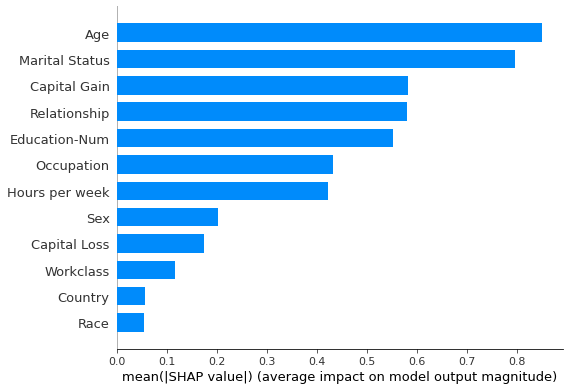

In [45]:
shap.initjs()
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

From the above simple bar chart, we observe that Age and Marital Features are the top 2 important features while determining the income. 

On the other hand, Country and Race are the least important features while determining the income.

## SHAP Summary Plot
Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 

* Features are sorted by the sum of the SHAP value magnitudes across all samples. 

* Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

* The syntax of summary plots is `summary_plot(shap_values[, features, …])`.

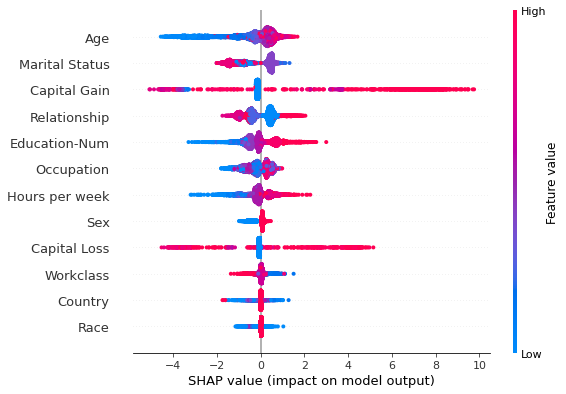

In [46]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

In the above plot, we have provided all the features in X_test to the Summary Plot. We can also provide some specific features instead. 

* It is interesting to note that the age and marital status feature has more total model impact than the capital gain feature. (Since they lie on the top and the Feature Value bar indicates high there).

* But, for those samples where capital gain matters, it has more impact than age or marital status. (Since its SHAP value is the highest amongst all).

* In other words, capital gain affects a few predictions by a large amount, while age or marital status affects all predictions by a smaller amount.

## SHAP Dependence Plots
* SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. 

* They plot a feature’s value vs. the SHAP value of that feature across many samples. 

* The syntax of Dependence Plots is `dependence_plot(ind[, shap_values, …])`.

* The attributes of the Dependence Plot can be understood as follows: 
    * **ind** = index of the feature we want to plot or the feature name
    * **interaction_index** = used to explicitly set which feature gets used for coloring
    * **shap_values** = matrix of SHAP values that we generated earlier
    * **features** = The data to be used for generating the dependence plot

* SHAP dependence plots account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. 

* The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

### PDP of ‘Age’ affecting model prediction
Let’s take a look at how the Age feature affects model predictions. 



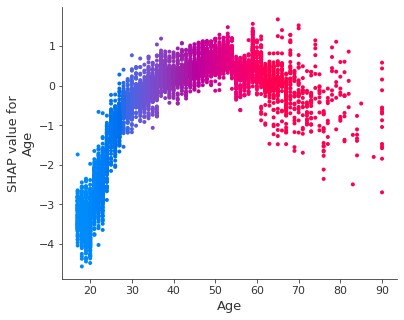

In [47]:
shap.initjs()
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test)

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model’s prediction decisions to say that these individuals make more money as compared to younger or older people

### PDP of ‘Education-Num’ affecting model prediction
Let’s take a look at how the Education-Num feature affects model predictions.

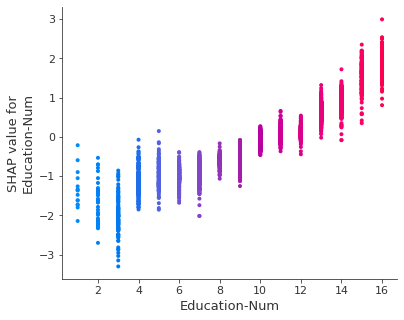

In [48]:
shap.initjs()
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test)

Higher education levels have higher shap values, pushing the model’s prediction decisions to say that these individuals make more money as compared to people with lower education levels.

### PDP of ‘Relationship’ affecting model prediction
Let’s take a look at how the Relationship feature affects model predictions.

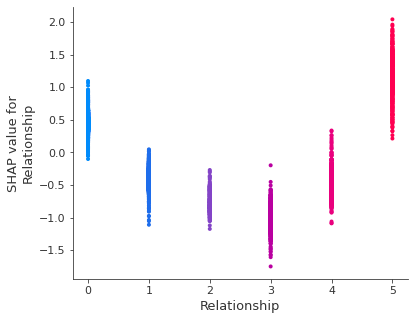

In [49]:
shap.initjs()
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test)

Just like we observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model’s prediction decisions to say that these individuals make more money as compared to other folks!

### PDP of ‘Capital Gain’ affecting model prediction
Let’s take a look at how the Capital Gain feature affects model predictions.

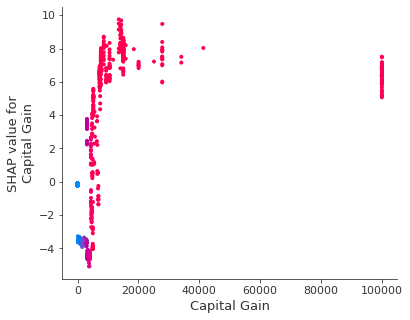

In [50]:
shap.initjs()
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test)

### Two-way PDP showing interactions between features ‘Age’ and ‘Capital Gain’ and their effect on making more than $50K
The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. 

Here we are trying to see interactions between Age and Capital Gain and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

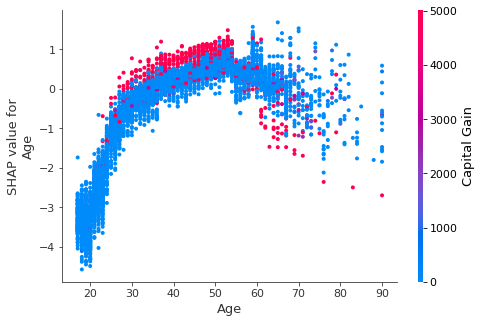

In [51]:
shap.initjs()
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

Interesting to see higher the higher capital gain and the middle-aged folks (30–50) having the highest chance of making more money!

### Two-way PDP showing interactions between features ‘Education-Num’ and ‘Relationship’ and their effect on making more than $50K
Here we are trying to see interactions between Education-Num and Relationship and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

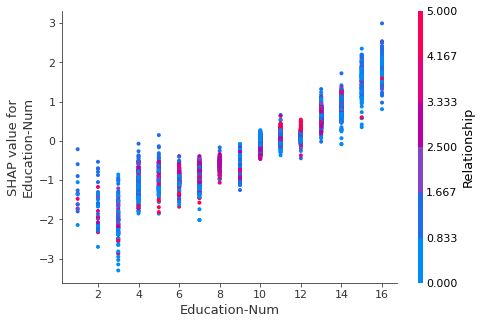

In [52]:
shap.initjs()
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test)

This is interesting because both the features are similar in some context, we can see typically educated and married people with relationship status of either husband(shown by light blue) or wife(shown by red) having the highest chance of making more money!

### Two-way PDP showing interactions between features ‘Marital Status’ and ‘Relationship’ and their effect on making more than $50K
Here we are trying to see interactions between Marital Status and Relationship and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.


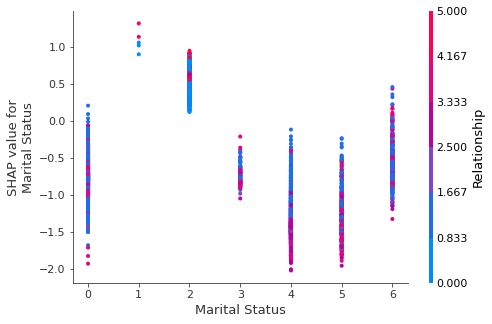

In [53]:
shap.initjs()
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test)

Interesting to see higher the higher education level and the husband or wife (married) folks having the highest chance of making more money!

### Two-way PDP showing interactions between features ‘Age’ and ‘Hours per week’ and their effect on making more than $50K
Here we are trying to see interactions between Age and Hours per week and also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

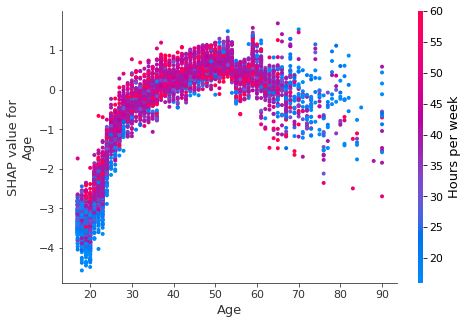

In [54]:
shap.initjs()
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test)

Nothing extra-ordinary here, middle-aged people working the most make the most money!

## Conclusion
Great to see you at the end of a long notebook! 
This notebook introduced you to the amazing things you can do with SHAP. 

The possibilities are endless, pick up a new dataset and explore it on your own!

## References
https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608 